In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse, TestSynapse
from jaxley_mech.channels.fm97 import Na, K, KA, KCa, Ca, Leak

import warnings
import networkx as nx
from jaxley.connection import connect
import pandas as pd

In [10]:
dt = 0.025
t_max = 100.0
time_vec = np.arange(0, t_max+2*dt, dt)

i_delay = 10.0
i_dur = 80.0
i_amp = 5.0  # nA
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
np.random.seed(0)

In [43]:
comp = jx.Compartment()
branch = jx.Branch([comp for _ in range(4)])
cell = jx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 1, 2, 2]))
net = jx.Network([cell]*3)
connect(net[0,0,0], net[1,0,0], IonotropicSynapse())
connect(net[0,0,1], net[1,0,1], IonotropicSynapse())
connect(net[0,0,1], net[1,0,1], TestSynapse())
net.cell(2).add_to_group("cell2")
net.cell(2).branch(1).add_to_group("cell2brach1")


net.cell(0).insert(Na())
net.cell(0).insert(Leak())

net.cell(1).branch(1).insert(Na())
net.cell(0).insert(K())
net.compute_xyz()

net.cell(0).branch(0).loc(0.0).record()
net.cell(0).branch(0).loc(0.0).record("m")
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.cell(0).branch(2).loc(0.0).stimulate(current)
net.cell(0).branch(1).make_trainable("Na_gNa")
net.cell(0).make_trainable("K_gK")
net.cell(1).branch("all").comp("all").make_trainable("Na_gNa", [.0,.1,.2,.3])

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 stimuli. See `.currents` for details.
Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 4. Total number of trainable parameters: 6


/home/jnsbck/Uni/PhD/projects/jaxley_project/jaxley/jaxley/modules/base.py:1432: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pointer.edges = pd.concat(


In [101]:
from jaxley.io.graph import to_graph, from_graph, impose_branch_structure, compartmentalize_branches
from jaxley.io.swc import swc_to_jaxley, swc_to_graph

In [152]:
# test exporting and re-importing of different modules
for module in [net, cell, branch, comp]:
    module_graph = to_graph(module) # ensure to_graph works
    re_module = from_graph(module_graph) # ensure prev exported graph can be read
    re_module_graph = to_graph(re_module) # ensure to_graph works on re-imported module


# import edge graph to jaxley
sets_of_edges = [[(0,1), (1,2), (1,3)], [(0,1)]]
for edges in sets_of_edges:
    edge_graph = nx.DiGraph(edges)
    edge_module = from_graph(edge_graph)

# import swc file to jaxley
fname = "../tests/morph.swc"
graph = swc_to_graph(fname)
swc_module = from_graph(edge_graph)

# import exported module to jaxley
module_graph = to_graph(module) 
exported_module = from_graph(module_graph) 

In [501]:
# xyz_coords = np.array([list(nx.get_node_attributes(new_graph, x).values()) for x in "xyz"])
# center = np.mean(xyz_coords, axis=1)
# # find node closest to center
# center_node = np.argmin(np.sum((xyz_coords - center[:, None])**2, axis=0))

In [27]:
fname = "../tests/morph.swc"
graph = swc_to_graph(fname)
# graph = impose_branch_structure(graph)
# new_graph = compartmentalize_branches(graph)
cell = from_graph(graph)

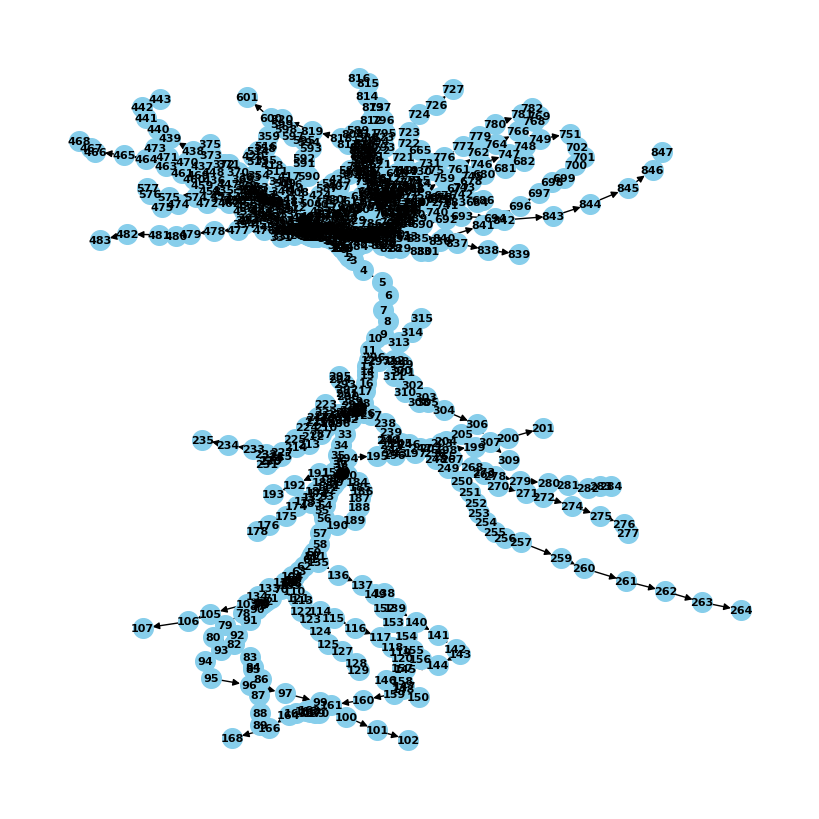

In [458]:
pos = {i: (n["x"], n["y"]) for i, n in new_graph.nodes(data=True)}
plt.figure(figsize=(8, 8))
nx.draw(new_graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", font_family="sans-serif")
plt.show()

In [ ]:
# interpolate xyzr continously along the graph
# compute best split of the graph into compartments (groupwise?)

In [775]:
mapper = get_depth_first_branch_indexes(graph, nseg=4, return_mapper=True)
nx.set_node_attributes(graph, mapper, "branch_index")

In [15]:
from jaxley.io.graph import to_graph, from_graph, build_skeleton_module

In [115]:
edges = [(0,1),(1,2),(2,3), (3,4),(4,5),(5,6), (3,8),(8,9),(9,10)]
graph = nx.DiGraph()
graph.add_edges_from(edges)


# module = from_graph(graph)
# module.compute_xyz()
# module.vis()

In [106]:
nsegs = 4; max_branch_len = 100

pathgraphs = []
max_branch_idx = 0

for i,j in graph.edges:
    graph.edges[i,j]["length"] = 1

# segment linear sections of the graph/morphology
all_linear_paths  = get_linear_paths(graph)
for path_edges in all_linear_paths:
    # get node and edge attrs
    path_nodes = path_e2n(path_edges)
    node_attrs = [graph.nodes[i] for i in path_nodes]
    lengths = [graph.edges[(i,j)]["length"] for i,j in path_edges]
    if "x" in node_attrs[0].keys():
        xyzr = np.stack([[n[k] for k in "xyzr"] for n in node_attrs])
    else:
        xyzr = np.stack([[float("nan") for k in "xyzr"] for n in node_attrs])

    if "id" in node_attrs[0].keys():
        ids = np.array([n["id"] for n in node_attrs])
    else:
        ids = np.array([0 for n in node_attrs])

    # segment morphology into branches based on nseg and max_branch_len
    pathlens = np.cumsum(np.array([0]+lengths))
    total_pathlen = pathlens[-1]
    num_branches = int(total_pathlen / max_branch_len) + 1
    
    # index branches
    branch_inds = (max_branch_idx + np.arange(num_branches).repeat(nsegs))
    max_branch_idx = branch_inds[-1] + 1
    
    # compute where to place compartment centers along morphology
    comp_len = total_pathlen / (num_branches*nsegs)
    locs = np.linspace(comp_len / 2, total_pathlen-comp_len / 2, num_branches*nsegs)
    new_path_nodes = np.interp(locs, pathlens, path_nodes) + 0.1*np.random.randn()
    
    # interpolate xyzr and ids along the morphology
    new_xyzr = vmap(jnp.interp, in_axes=(None, None, 1))(locs, pathlens, xyzr)
    new_ids = np.interp(locs, pathlens, ids).astype(int)

    # construct graph for segemented morphology 
    keys = ["x", "y", "z", "r", "id", "branch_index"]
    new_node_attrs = zip(*new_xyzr.tolist(), new_ids, branch_inds)
    new_node_attrs = [{k:v for k,v in zip(keys, items)} for items in new_node_attrs]

    pathgraph = nx.DiGraph(path_n2e(new_path_nodes))
    pathgraph.add_nodes_from(zip(new_path_nodes, new_node_attrs))
    pathgraph.add_nodes_from(new_path_nodes)
    pathgraphs.append(pathgraph)

# combine linear paths
new_graph = nx.union_all(pathgraphs)

# connect linear subgraphs according to the original graph
linear_path_edges = np.array([(path[0][0], path[-1][-1]) for path in all_linear_paths])
edges_between_linear_paths = list(zip(*np.where(np.equal(*np.meshgrid(*(linear_path_edges.T))))))
new_edges_between_linear_paths = [(max(pathgraphs[i]), min(pathgraphs[j])) for i,j in edges_between_linear_paths]
new_graph.add_edges_from(new_edges_between_linear_paths)

# reconnect root
root_edges = list(zip(*np.where([linear_path_edges[:,0] == 0])))[1:] # drop (0,0)
new_root_edges = [(min(pathgraphs[i]), min(pathgraphs[j])) for i,j in root_edges]
new_graph.add_edges_from(new_root_edges)

# rename nodes by enumeration (since nodes idxs were interpolated)
new_keys = {k: i for i, k in enumerate(new_graph.nodes)}
new_graph = nx.relabel_nodes(new_graph, new_keys)

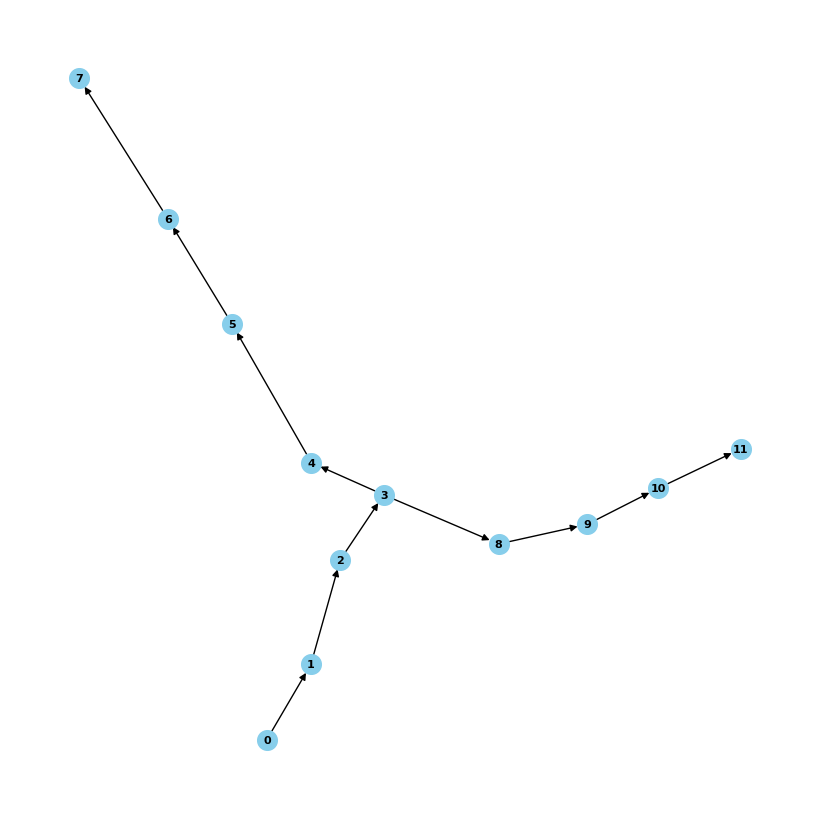

In [107]:
plt.figure(figsize=(8, 8))
nx.draw(new_graph, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", font_family="sans-serif")
plt.show()

In [512]:
# df = pd.DataFrame((net.trainable_params,net.indices_set_by_trainables, []), index=["param", "index", "value"])
# df = df.T.explode("index").explode("index").reset_index(drop=True)
# split_col = df["param"].apply(lambda d: next(iter(d.items())))
# df[["param", "value"]] = pd.DataFrame(split_col.tolist())
# df = df.astype({"index": int, "value": float, "param": str})
# trainable_iter = {i: {k:np.array([v]) for i,(k,v) in group[["param", "value"]].iterrows()} for i,group in  df.groupby("index")}

In [479]:
# trainable_inds = np.unique(np.hstack(net.indices_set_by_trainables))
# trainable_params = {i:{} for i in trainable_inds}
# for i in trainable_inds:
#     for inds, params in zip(net.indices_set_by_trainables, net.trainable_params):
#         if i in inds.flatten():
#             trainable_params[i].update(params)
# trainable_iter = {k:{"trainables":v} for k,v in trainable_params.items()}
# module_graph.add_nodes_from(trainable_iter.items())

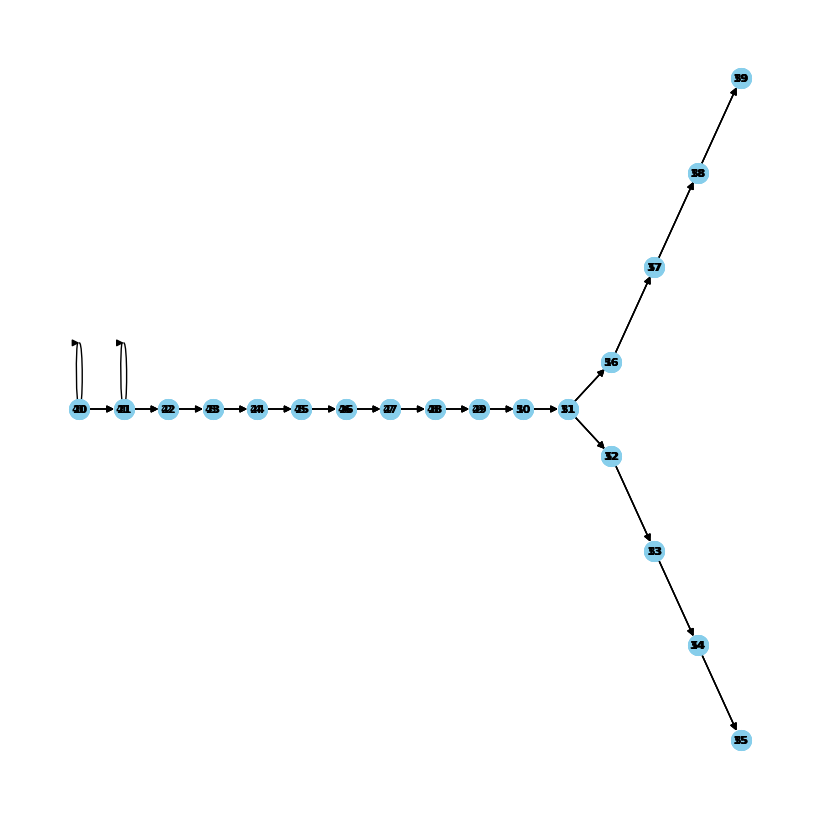

In [23]:
# plot the graph
pos = {i: (n["x"], n["y"]) for i, n in module_graph.nodes(data=True)} 
plt.figure(figsize=(8, 8))
nx.draw(module_graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", font_family="sans-serif")
plt.show()

In [ ]:
# # since the original xyzr is not known, one cannot know where xyzr was measured
# # and where it was interpolated. Therefore, original.xyzr and from_graph.xyzr
# # will probably differ.
# if "x" in nodes.columns:
#     # interpolate xyzr between first and last only
#     first_branch_inds = nodes.reset_index().groupby("branch_index").first()["index"].values
#     last_branch_inds = nodes.reset_index().groupby("branch_index").last()["index"].values
#     first_xyzr = nodes.loc[first_branch_inds][["x", "y", "z", "radius"]]
#     last_xyzr = nodes.loc[last_branch_inds][["x", "y", "z", "radius"]]
#     dl = last_xyzr[["x", "y", "z"]].values - first_xyzr[["x", "y", "z"]].values
#     first_xyzr[["x", "y", "z"]] = first_xyzr[["x", "y", "z"]]-1/2*dl/(module.nseg-1)
#     last_xyzr[["x", "y", "z"]] = last_xyzr[["x", "y", "z"]]+1/2*dl/(module.nseg-1)
#     xyzr = [np.vstack([first, last]) for first, last in zip(first_xyzr.values, last_xyzr.values)]

### Ideas:
- add a `groups` property
- show group membership in nodes
- make use to to_graph in plotting
- make use of from graph in swc import
- modules can be saved as graph, no need for pickle necessarily
- prevent untrainable stuff, like `Na` from being made trainable!
- Do we really want to enforce nsegs equal? is it required?